# Time Series Forecasting using Gaussian Process Regression

In [1]:
%matplotlib inline

# ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

# data manipulation
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from pylab import rcParams
import scipy

# set font scale and style
plt.rcParams.update({'font.size': 18})

# gpr 
from sklearn.gaussian_process import GaussianProcessRegressor as GPR
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.gaussian_process.kernels import RationalQuadratic, ExpSineSquared

# preprocessing
from sklearn.preprocessing import StandardScaler, PowerTransformer
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.graphics.gofplots as sm

In [2]:
# import custom class
%run -i '../src/time_series.py'

In [3]:
# instantiate the class
ts_fcst = TimeSeriesForecasting()

# Load  data

In [4]:
ts = pd.read_csv('../data/ts_data.csv') # load data
ts.date = pd.to_datetime(ts['date'])  # convert to datetime
ts.index = ts.date # make date the dataframe index
ts = ts.drop(['date'], axis =1)
ts.dropna(inplace = True) # drop rows with missing values
print("Data size:", ts.shape)
ts.head()

Data size: (77, 3)


,sales,year,month
date,,,
2015-01-01,154.0,2015,1
2015-02-01,96.0,2015,2
2015-03-01,73.0,2015,3
2015-04-01,49.0,2015,4
2015-05-01,36.0,2015,5


## Feature engineering

In [5]:
ts['yr_mnth'] = ts.year + ts.month/12

## Create a test  set
We must split the dataset into training and test (out-of-sample) set. 

In [6]:
train_start, train_end = '2015-01-01','2020-05-01'
test_start, test_end = '2020-05-01', '2021-05-01'

cols_to_drop = ['sales']
x_train = ts.drop(cols_to_drop, axis =1)[train_start: train_end]
y_train = ts['sales'][train_start: train_end]

x_test = ts.drop(cols_to_drop, axis =1)[test_start: test_end]
y_test = ts['sales'][test_start: test_end]

## Standardization

In [7]:
# standardization
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

## Gaussian Process Regression (GPR)

In [8]:
# train gpr
kernel = RBF(length_scale = np.ones(x_train.shape[1], )) + WhiteKernel(noise_level=0.1)
gpr = GPR(
    kernel=kernel, 
    n_restarts_optimizer=0, 
    normalize_y=True, 
    random_state=42,
    )
gpr.fit(x_train_scaled, y_train)

GaussianProcessRegressor(kernel=RBF(length_scale=[1, 1, 1]) + WhiteKernel(noise_level=0.1),
                         normalize_y=True, random_state=42)

# Training set (in-sample) prediction

In [9]:
# prediction on the training set
y_pred, std = gpr.predict(x_train_scaled, return_std=True)
print("Training set performance errors")
print(30*"-")
ts_fcst.error_metrics(y_train, y_pred)

Training set performance errors
------------------------------


{'MAPE': 9.226,
 'WMAPE': 6.34,
 'MASE': 0.254,
 'MAE': 16.697,
 'RMSE': 20.967,
 'R^2': 0.984}

## Model Diagnostics on the Training Set

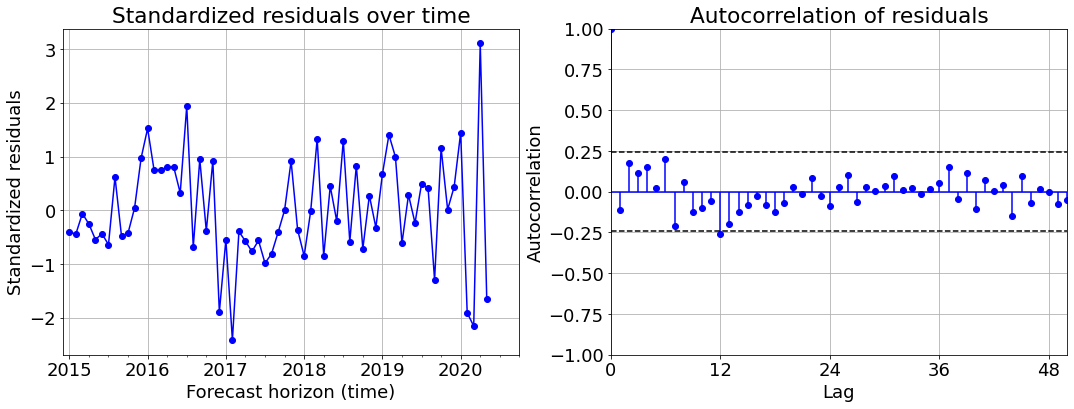

In [10]:
plt.figure(figsize = (18,6))
tresidual = y_train-y_pred
tstandard = (tresidual-np.mean(tresidual))/np.std(tresidual)
ape = np.abs(tresidual)*100/np.abs(y_train)

plt.subplot(121)
tstandard.plot(color = 'b', marker = 'o')
plt.grid(True)
plt.xlabel('Forecast horizon (time)')
plt.ylabel('Standardized residuals')
plt.xlim('2014-12-01', '2020-10-01')
plt.title('Standardized residuals over time')

plt.subplot(122)
plt.acorr(tresidual, usevlines=True, maxlags=50, normed=True, color ='b')
plt.acorr(tresidual, usevlines=False, maxlags=50, normed=True,color ='b')
plt.axhline(y=1.96/np.sqrt(len(tresidual)),linestyle= '--', linewidth=1.5, color = 'k')
plt.axhline(y=-1.96/np.sqrt(len(tresidual)),linestyle= '--', linewidth=1.5, color = 'k')
plt.xlim(0,50)
plt.ylim(-1,1)
plt.xticks(np.arange(0,50,12))
plt.grid(True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of residuals')
plt.show()

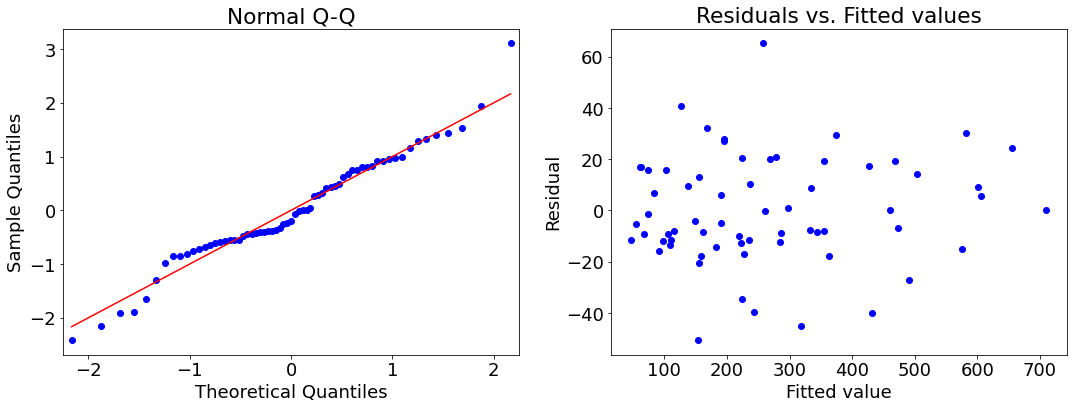

In [11]:
fig, ax = plt.subplots(1,2,figsize = (18,6))
sm.ProbPlot(tstandard).qqplot(line='s', ax=ax[0])
ax[0].set_title('Normal Q-Q')

ax[1].scatter(y_pred, tresidual, color = 'b')
ax[1].set_title('Residuals vs. Fitted values')
ax[1].set_xlabel('Fitted value')
ax[1].set_ylabel('Residual')
plt.show()

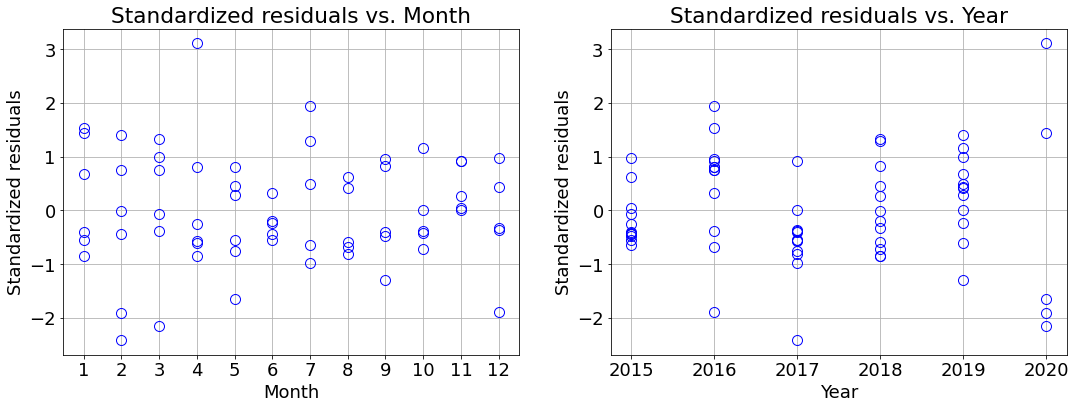

In [12]:
plt.figure(figsize = (18,6))
plt.subplot(121)
plt.plot(
    tstandard.index.month, 
    tstandard, 
    color='b', 
    marker='o', 
    markerfacecolor='none',
    linestyle='', 
    markersize=10,
    )
plt.grid(True)
plt.xlabel('Month')
plt.ylabel('Standardized residuals')
plt.xticks(np.arange(1,13,1))
plt.title('Standardized residuals vs. Month')

plt.subplot(122)
plt.plot(
    tstandard.index.year, 
    tstandard, 
    color='b', 
    marker='o', 
    markerfacecolor='none',
    linestyle='',
     markersize=10,
     )
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Standardized residuals')
plt.xticks(np.arange(2015,2021))
plt.title('Standardized residuals vs. Year')
plt.show()

# Test (out-of-sample) prediction

In [13]:
# make prediction
yhat, std = gpr.predict(x_test_scaled, return_std=True)
print("Test set performance errors")
print(30*"-")
ts_fcst.error_metrics(y_test, yhat)

Test set performance errors
------------------------------


{'MAPE': 15.101,
 'WMAPE': 15.52,
 'MASE': 0.615,
 'MAE': 72.205,
 'RMSE': 94.29,
 'R^2': 0.84}

In [14]:
yhat[yhat<0] = 0

ylow = yhat -2*std
ylow[ylow<0] = 0

yhigh = yhat + 2*std
yhigh[yhigh<0] = 0

results = pd.DataFrame()
results['yhat'] = yhat
results['ylow'] = ylow
results['yhigh'] = yhigh
results.index = y_test.index

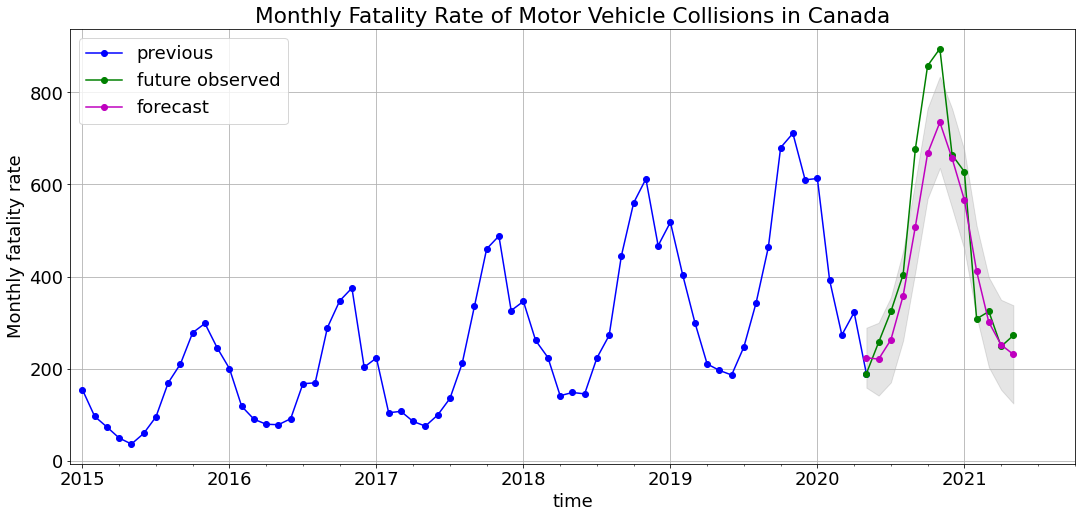

In [15]:
plt.figure(figsize = (18,8))

y_train.plot(label='previous',  marker='o', color='b')
y_test.plot(label='future observed', marker='o', color='g')
results['yhat'].plot(label='forecast', marker='o', color='m')

plt.fill_between(
    results.index, 
    results['ylow'], 
    results['yhigh'], 
    color='k', 
    alpha=0.1,
    )
plt.xlabel('time')
# plt.text('2014-02-01', 0.021, "WMAPE = 1.5%")
plt.grid(True)
plt.ylabel('Monthly fatality rate')
plt.title('Monthly Fatality Rate of Motor Vehicle Collisions in Canada')
plt.xlim('2014-12-01', '2021-10-01')
plt.legend()
plt.savefig('../img/gpr.png')
plt.show()

## Model Diagnostics on the Test Set

## 1. Residuals of the test set 
The residuals plots displayed below show that the standardized residuals fall between -3 and 3, which suggests the residuals are normally distributed.  The sample autocorrelation function (ACF) of the residuals shows that the residuals are approximately uncorrelated, behaving a white noise.

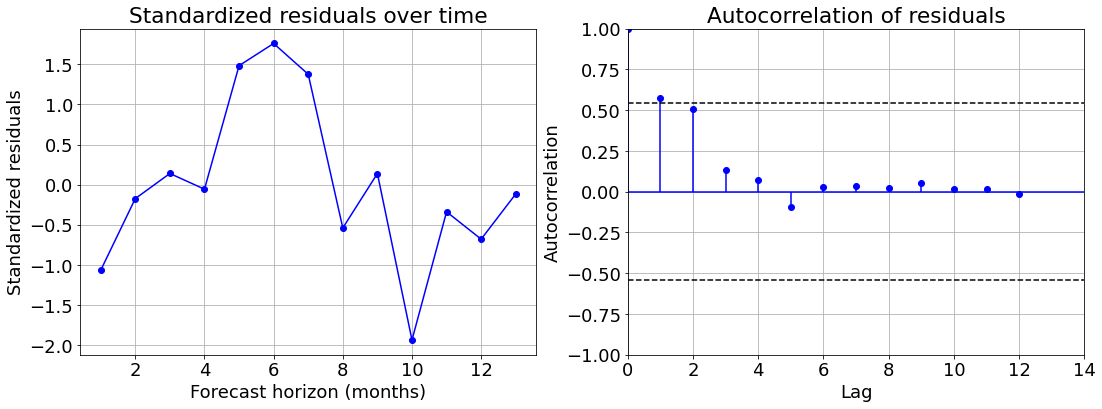

In [16]:
plt.figure(figsize = (18,6))
residual = y_test-results['yhat']
rstandard = (residual-np.mean(residual))/np.std(residual)
ape = np.abs(residual)*100/np.abs(y_test)

plt.subplot(121)
plt.plot(range(1,len(rstandard)+1), rstandard, color='b', marker='o')
plt.grid(True)
plt.xlabel('Forecast horizon (months)')
plt.ylabel('Standardized residuals')
# plt.xticks(np.arange(0,len(rstandard)+1,12))
plt.title('Standardized residuals over time')

plt.subplot(122)
plt.acorr(residual, usevlines=True, maxlags=len(residual)-1, normed=True, color='b')
plt.acorr(residual, usevlines=False, maxlags=len(residual)-1, normed=True,color='b')
plt.axhline(y=1.96/np.sqrt(len(residual)),linestyle='--', linewidth=1.5, color='k')
plt.axhline(y=-1.96/np.sqrt(len(residual)),linestyle='--', linewidth=1.5, color='k')
plt.xlim(0,len(residual)+1)
plt.ylim(-1,1)
# plt.xticks(np.arange(0,len(residual)+1,12))
plt.grid(True)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation of residuals')
plt.show()

## 2. Ljung-Box test

A good forecasting model will have zero correlation between its residuals. Correlation in residuals means that some information were left out which should have been used in forecasting.

We use the Ljung-Box test to check if the residuals (absolute percent error) from the time series model resemble white noise (i.e., zero autocorrelation). The null hypothesis states that the residuals are independently and identically distributed, that is the errors are uncorrelated. Therefore, a p-value greater than the type I error $\alpha = 0.05$ means that we do not have enough information (or statistically significant evidence) to reject the null hypothesis. However, this does not mean that the forecasting model cannot be improved.

The p-values of the Ljung-Box test for various lags show that some 
of the Ljung-Box test p-values are larger than $\alpha = 0.05$.

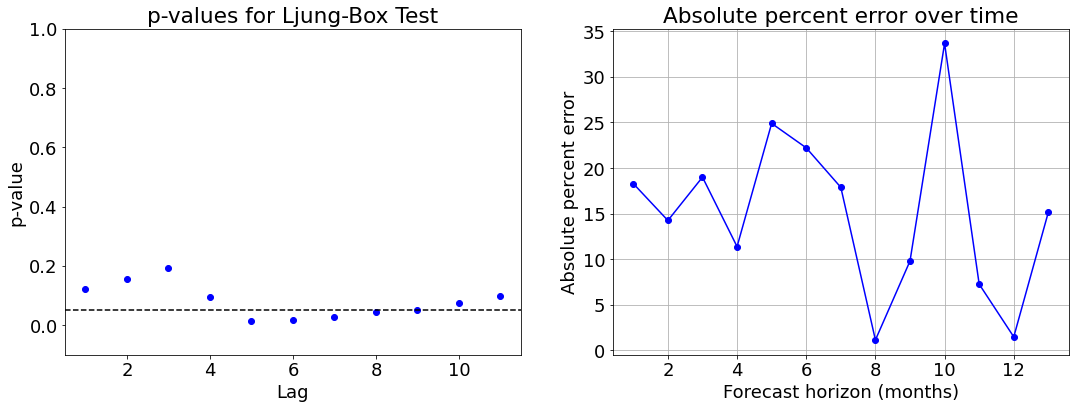

In [17]:
plt.figure(figsize = (18,6))
plt.subplot(121)
lb = acorr_ljungbox(residual, lags = 11)[1]
plt.plot(np.arange(1,len(lb)+1), lb, 'o', color = 'b')
plt.axhline(y=0.05,linestyle= '--', color = 'k')
plt.ylabel('p-value')
plt.xlabel('Lag')
# plt.xticks(np.arange(0,len(lb),6))
plt.ylim(-0.1,1)
plt.title('p-values for Ljung-Box Test')

plt.subplot(122)
plt.plot(range(1,len(ape)+1), ape, color = 'b', marker = 'o')
plt.grid(True)
plt.xlabel('Forecast horizon (months)')
plt.ylabel('Absolute percent error')
plt.title('Absolute percent error over time')
label = ['0%', '5%', '10%']
# plt.xticks(np.arange(0,len(ape)+1,12))
# plt.yticks(np.arange(0,12,5),label)
# plt.savefig('../images/figlb.png')
plt.show()